In [1]:
from sklearn.linear_model import LogisticRegression 
from resemblyzer import preprocess_wav, VoiceEncoder
from demo_utils import *
from pathlib import Path
from tqdm import tqdm
import numpy as np
from itertools import groupby

In [2]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False # 유니코드 깨짐현상 해결
plt.rcParams["font.family"] = 'NanumGothic'

### audio preprocessing

In [ ]:
import os, sys
from os.path import dirname, abspath, basename, exists, splitext
from os.path import join as joinPath

DUPLICATE_MARKER = '1'

def flattenFiles( here ):
    '''Move all files in subdirs to here, then delete subdirs.
       Conflicting files are renamed, with 1 appended to their name.'''
    for root, dirs, files in os.walk( here, topdown=False ):
        if root != here:
            for name in files:
                source = joinPath( root, name )
                target = handleDuplicates( joinPath( here, name ) )
                os.rename( source, target )

        for name in dirs:
            os.rmdir( joinPath( root, name ) )

def handleDuplicates( target ):
    while exists( target ):
        base, ext = splitext( target )
        target    = base + DUPLICATE_MARKER + ext
    return target

In [ ]:
#root = '/home/kwangje/Desktop/Resemblyzer/audio_data/iptv_uttr/total/'
#sorted(os.listdir(root))
#flattenFiles(root+'허설')

## Demo-03: umap projection

#### sample : 10명

In [3]:
wav_fpaths = list(Path("audio_data", "iptv_uttr", "sample").glob("**/*.wav"))
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), position=0))))
speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in 
                groupby(range(len(wavs)), lambda i: speakers[i])}

Preprocessing wavs: 100%|██████████| 1580/1580 [00:11<00:00, 138.61it/s]


In [4]:
for key, value in sorted(speaker_wavs.items()):
    print(key, len(value))

김나영 152
김윤재 152
김지현 161
김진주 151
김훈 183
류성균 157
문성재 140
박민선 151
박상훈 147
박지웅 186


In [4]:
## Compute the embeddings
encoder = VoiceEncoder()
utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))

Loaded the voice encoder model on cuda in 1.27 seconds.


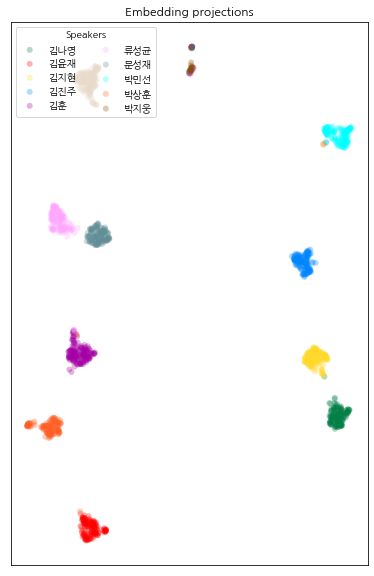

In [16]:
## Project the embeddings in 2D space
plot_projections(utterance_embeds, speakers, title="Embedding projections")
plt.show()

In [23]:
wav_fpaths_2 = list(Path("audio_data", "iptv_uttr", "sample2").glob("**/*.wav"))
speakers_2 = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths_2))
wavs_2 = np.array(list(map(preprocess_wav, tqdm(wav_fpaths_2, "Preprocessing wavs", len(wav_fpaths_2), position=0))))
speaker_wavs_2 = {speaker: wavs_2[list(indices)] for speaker, indices in 
                    groupby(range(len(wavs_2)), lambda i: speakers_2[i])} 

Preprocessing wavs: 100%|██████████| 1608/1608 [00:11<00:00, 140.39it/s]


In [25]:
## Compute the embeddings
encoder_2 = VoiceEncoder()
utterance_embeds_2 = np.array(list(map(encoder_2.embed_utterance, wavs_2)))

Loaded the voice encoder model on cuda in 0.01 seconds.


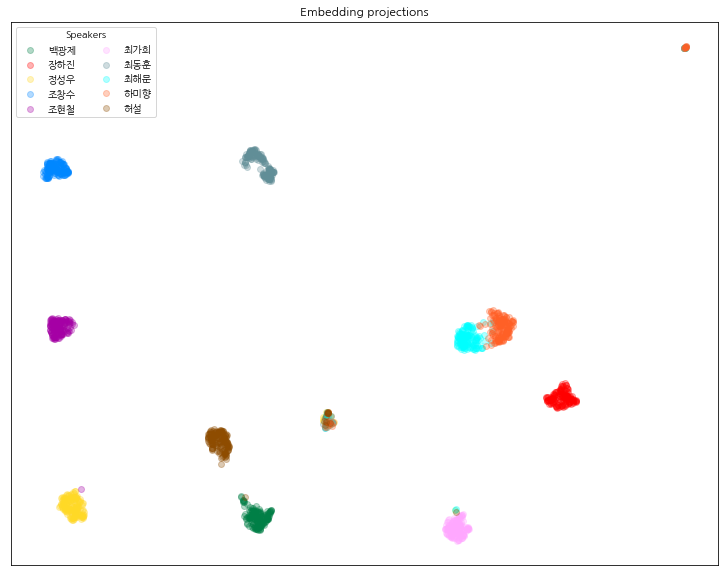

In [31]:
plot_projections(utterance_embeds_2, speakers_2, title="Embedding projections")
plt.show()

In [ ]:
# compute similarity 
fpath = Path('/home/kwangje/Desktop/Resemblyzer/audio_data/iptv_uttr/test/record_163357.pcm.wav')
wav = preprocess_wav(fpath)
embed = encoder.embed_utterance(wav)
np.set_printoptions(precision=3, suppress=True)
print(embed)

## Demo-01: similarity compute

In [ ]:
encoder01 = VoiceEncoder()

In [ ]:
wav_fpaths = list(Path("audio_data", "iptv_uttr", "sample").glob("**/*.wav"))

In [ ]:
# group the wavs per speaker
# load them using the func: preprocess_wav(), and load wavs in memory
# normalizes the volume, and trim long silences, and resamples the wav 
speaker_wavs = {speaker: list(map(preprocess_wav, wav_fpaths)) for speaker, wav_fpaths in
                groupby(tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit="wavs", position=0), 
                        lambda wav_fpath: wav_fpath.parent.stem)}

In [ ]:
embeds_a = np.array([encoder01.embed_utterance(wavs[0]) for wavs in speaker_wavs.values()])
embeds_b = np.array([encoder01.embed_utterance(wavs[1]) for wavs in speaker_wavs.values()])

In [ ]:
print(embeds_b.shape)

In [ ]:
print(embeds_b[0].shape)

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np
distance = np.mean(cdist(embeds_a, embeds_b, metric='cosine'))

In [ ]:
print(distance)

In [ ]:
print("Shape of embeddings: %s" % str(embeds_a.shape))

In [ ]:
# similarity matrix: cosine distance, L2
utt_sim_matrix = np.inner(embeds_a, embeds_b)
utt_sim_matrix2 = np.zeros((len(embeds_a), len(embeds_b))) # long, detailed version

In [ ]:
for i in range(len(embeds_a)):
    for j in range(len(embeds_b)):
        utt_sim_matrix2[i, j] = embeds_a[i] @ embeds_b[j] 
        # utt_sim_matrix2[i, j] = np.matmul(embeds_a[i], embeds_b[i])  
assert np.allclose(utt_sim_matrix, utt_sim_matrix2) 

- Similarity between two speaker embeddings
    * Divide the utterances of each speaker in groups of identical size
    * embed each group as a speaker embedding

In [ ]:
spk_embeds_a = np.array([encoder01.embed_speaker(wavs[:len(wavs) // 2]) \
                         for wavs in speaker_wavs.values()])

In [ ]:
spk_embeds_a.shape

In [ ]:
for wavs in speaker_wavs.values():
    x= wavs[:len(wavs)][0]
    y= wavs[:len(wavs) // 2][0]
    print(x==y)

In [ ]:
for spk, wavs in speaker_wavs.items():
    # print(spk[:len(spk)], wavs[:len(wavs)][0])
    print(spk[:len(spk)], len(wavs[:len(wavs) // 2]))

In [ ]:
for wavs in speaker_wavs.values():
    print(wavs[:len(wavs)][0])
    #print(wavs[:len(wavs) // 2][0])

In [ ]:
for wavs in speaker_wavs.values():
    # print(wavs[:len(wavs)][0])
    print(wavs[:len(wavs) // 2][0])

In [ ]:
for wavs in speaker_wavs.values():
    print(wavs[:len(wavs)][1])
    #print(wavs[:len(wavs) // 2][1])

In [ ]:
spk_embeds_a = np.array([encoder01.embed_speaker(wavs[:len(wavs) // 2]) \
                         for wavs in speaker_wavs.values()])
spk_embeds_b = np.array([encoder01.embed_speaker(wavs[len(wavs) // 2:]) \
                         for wavs in speaker_wavs.values()])

In [ ]:
spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)

In [ ]:
spk_sim_matrix

In [ ]:
labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
labels_a

In [ ]:
len(utt_sim_matrix)

In [ ]:
mask = np.eye(len(utt_sim_matrix), dtype=np.bool)
mask

In [ ]:
## Draw the plots
fix, axs = plt.subplots(2, 2, figsize=(8, 10))
plt.subplots_adjust(hspace=0.4)
labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
mask = np.eye(len(utt_sim_matrix), dtype=np.bool)

plot_similarity_matrix(utt_sim_matrix, labels_a, labels_b, axs[0, 0],
                       "Cross-similarity between utterances\n(speaker_id-utterance_group)")
plot_histograms((utt_sim_matrix[mask], utt_sim_matrix[np.logical_not(mask)]), axs[0, 1],
                ["Same speaker", "Different speakers"], 
                "Normalized histogram of similarity\nvalues between utterances")

plot_similarity_matrix(spk_sim_matrix, labels_a, labels_b, axs[1, 0],
                       "Cross-similarity between speakers\n(speaker_id-utterances_group)")
plot_histograms((spk_sim_matrix[mask], spk_sim_matrix[np.logical_not(mask)]), axs[1, 1],
                ["Same speaker", "Different speakers"], 
                "Normalized histogram of similarity\nvalues between speakers")
plt.show()